In [19]:
# Provides ways to work with large multidimensional arrays
import numpy as np 
# Allows for further data manipulation and analysis
import pandas as pd
from pandas_datareader import data # Reads stock data 
import matplotlib.pyplot as plt # Plotting
import matplotlib.dates as mdates # Styling dates
%matplotlib inline

import datetime as dt # For defining dates
# import mplfinance as mpf # Matplotlib finance

import time

# Used to get data from a directory
import os
from os import listdir
from os.path import isfile, join

#Statsmodels is a great library we can use to run regressions.
import statsmodels.api as sm
# Seaborn extends the capabilities of Matplotlib
import seaborn as sns
# Used for calculating regressions
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

In [20]:
#change the tickers here according to what's in the portfolio
tickers = ['HSON','ISSC','KRNT','RCII','SAIA','AMD','EPAM','ASML',
          'AUDC','DSGX','MGIC','DHI','LULU','MBUU','MCRI','RUSHA',
          'CTLT','IDXX','BDSI','MEDP','MODV','RGEN','TROW','CG',
          'TBBK','FCX','NUE','SBAC','COP','QNST','TTGT','^FVX']

start_date = '2017-01-01'
end_date = '2022-01-01'

panel_data = data.DataReader(tickers,'yahoo', start_date, end_date)

In [21]:
#check that all stocks have the same amount of data otherwise change the date range

adj_close = panel_data['Adj Close']
adj_close.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2017-01-03 to 2021-12-31
Data columns (total 32 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   HSON    1259 non-null   float64
 1   ISSC    1259 non-null   float64
 2   KRNT    1259 non-null   float64
 3   RCII    1259 non-null   float64
 4   SAIA    1259 non-null   float64
 5   AMD     1259 non-null   float64
 6   EPAM    1259 non-null   float64
 7   ASML    1259 non-null   float64
 8   AUDC    1259 non-null   float64
 9   DSGX    1259 non-null   float64
 10  MGIC    1259 non-null   float64
 11  DHI     1259 non-null   float64
 12  LULU    1259 non-null   float64
 13  MBUU    1259 non-null   float64
 14  MCRI    1259 non-null   float64
 15  RUSHA   1259 non-null   float64
 16  CTLT    1259 non-null   float64
 17  IDXX    1259 non-null   float64
 18  BDSI    1259 non-null   float64
 19  MEDP    1259 non-null   float64
 20  MODV    1259 non-null   float64
 21  RGEN    1259 non-nu

## Function that saves dataframe to CSV

In [22]:
def save_dataframe_to_csv(kind, df, ticker):
    df.to_csv(kind + ticker + '.csv')

In [23]:
for ticker in tickers:
    panel_data = data.DataReader(ticker,'yahoo', start_date, end_date)
#     close = panel_data['Close']
    adj_close = panel_data['Adj Close']
    save_dataframe_to_csv('adj_close', adj_close, ticker)

## Function that returns dataframe from a CSV

In [24]:
def get_df_from_csv(kind, ticker):
    try:
        df = pd.read_csv(kind + ticker + '.csv', index_col='Date', 
                         parse_dates=True)
    except FileNotFoundError:
        pass
        # print("File Doesn't Exist")
    else:
        return df

## Add Daily Return to dataframe

In [25]:
def add_daily_return_to_df(kind, df, ticker):
    df['daily_return'] = (df['Adj Close'] / df['Adj Close'].shift(1)) - 1
    # Save data to a CSV file
    save_dataframe_to_csv(kind, df, ticker)
    return df

In [26]:
for ticker in tickers:
    df = get_df_from_csv('adj_close', ticker)
    add_daily_return_to_df('adj_close', df, ticker)

## Merge multiple stocks in one dataframe by col name

In [27]:
def merge_df_by_column_name(col_name, sdate, edate, *tickers):
    # Will hold data for all dataframes with the same column name
    mult_df = pd.DataFrame()
    
    for x in tickers:
        df = get_df_from_csv('adj_close', x)
        
        # NEW Check if your dataframe has duplicate indexes
        if not df.index.is_unique:
            # Delete duplicates 
            df = df.loc[~df.index.duplicated(), :]
        
        mask = (df.index >= sdate) & (df.index <= edate)
        mult_df[x] = df.loc[mask][col_name]
        
    return mult_df

## Get stock prices on date

In [28]:
def get_prices_on_date(stocks_df, date):
    return stocks_df.loc[pd.DatetimeIndex([date])]['Adj Close'].item()

## Returns the value of portfolio by date

In [29]:
def get_port_val_by_date(date, shares, tickers):
    port_prices = merge_df_by_column_name('Adj Close',  date, date, *port_list)
    # Convert from dataframe to Python list
    port_prices = port_prices.values.tolist()
    # Trick that converts a list of lists into a single list
    port_prices = sum(port_prices, [])
    
    # Create a list of values by multiplying shares by price
    value_list = []
    for price, share in zip(port_prices, shares):
        value_list.append(price * share)
    
    return sum(value_list)

## Find Daily Return for Whole Portfolio

In [30]:
def get_port_daily_return(sdate, edate, shares, tickers):
    # Merge all daily prices for all stocks into 1 dataframe
    mult_df = merge_df_by_column_name('Adj Close',  sdate, 
                                  edate, *port_list)
    
    # Get the number of stocks in portfolio
    num_cols = len(mult_df.columns)
    
    # Multiply each stock column by the number of shares
    i = 0
    while i < num_cols:
        mult_df[tickers[i]] = mult_df[tickers[i]].apply(lambda x: x * shares[i])
        i += 1
        
    # Create a new column with the sums of all stocks named Total
    mult_df['Total'] = mult_df.iloc[:, 0:num_cols].sum(axis=1)
    
    # Add column for portfolio daily return
    mult_df['daily_return'] = (mult_df['Total'] / mult_df['Total'].shift(1)) - 1
    
    return mult_df

In [31]:
#change to the list of stocks we using
port_list = ['HSON','ISSC','KRNT','RCII','SAIA','AMD','EPAM','ASML',
          'AUDC','DSGX','MGIC','DHI','LULU','MBUU','MCRI','RUSHA',
          'CTLT','IDXX','BDSI','MEDP','MODV','RGEN','TROW','CG',
          'TBBK','FCX','NUE','SBAC','COP','QNST','TTGT','^FVX']

#add in the weightage of stocks
port_shares = [0.007181667,0.002898889,0.011983333,0.007311111,0.026180556,0.006376111,0.013810556,0.014952778,
               0.008921667,0.008227222,0.003267778,0.01,0.031030556,0.0057,0.001186111,0.007639444,0.000592222,
               0.02066,0.004065,0.005232778,0.005361667,0.019643889,0.016286667,0.022943333,0.016325556,0.015356111,
               0.040199444,0.055555556,0.055555556,0.004451667,0.051103889,0.5]

# tot_port_df = get_port_daily_return('2020-01-02', '2020-12-31', 
#                                     port_shares, port_list)

#change the dates according to what you put on top
tot_port_df = get_port_daily_return('2017-01-01', '2022-01-01', port_shares, port_list)
tot_port_df

,HSON,ISSC,KRNT,RCII,SAIA,AMD,EPAM,ASML,AUDC,DSGX,...,TBBK,FCX,NUE,SBAC,COP,QNST,TTGT,^FVX,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,0.101980,0.008675,0.158779,0.077956,1.175507,0.072879,0.879180,1.576425,0.054815,0.174828,...,0.131584,0.203432,2.088881,5.783462,2.444622,0.016382,0.434383,0.9720,23.820178,NaN
2017-01-04,0.105571,0.008750,0.154585,0.078760,1.179434,0.072879,0.888847,1.568860,0.054150,0.176474,...,0.124074,0.218933,2.146351,5.791684,2.467325,0.017495,0.433872,0.9735,24.037456,0.009122
2017-01-05,0.104852,0.009024,0.149792,0.075076,1.150635,0.071667,0.894234,1.587700,0.052320,0.174006,...,0.117217,0.215833,2.134086,5.714958,2.460079,0.017362,0.436938,0.9315,23.854598,-0.007607
2017-01-06,0.103416,0.008974,0.151589,0.071996,1.174983,0.072178,0.923512,1.585987,0.053318,0.174828,...,0.117054,0.219966,2.112710,5.673307,2.450902,0.017139,0.431317,0.9610,23.885412,0.001292
2017-01-09,0.100543,0.009348,0.159978,0.072397,1.154562,0.073262,0.923098,1.605541,0.052486,0.174417,...,0.115911,0.216718,2.089933,5.644261,2.398734,0.017629,0.435405,0.9405,23.721994,-0.006842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,0.200009,0.018582,1.837764,0.359707,8.719434,0.984216,9.625958,12.133133,0.310920,0.673151,...,0.414506,0.643732,4.668858,21.297777,4.035668,0.082801,5.005626,0.6260,111.508763,0.022462
2021-12-28,0.202379,0.019133,1.826859,0.357733,8.644558,0.976501,9.421561,12.033547,0.308779,0.674632,...,0.408955,0.643732,4.580804,21.373890,4.030707,0.080842,4.939191,0.6225,110.585864,-0.008276
2021-12-29,0.201518,0.018959,1.849987,0.360876,8.781220,0.945322,9.361348,11.991829,0.310563,0.678252,...,0.416465,0.643579,4.598414,21.386112,4.019682,0.080620,4.939191,0.6470,110.855442,0.002438


## Get old data for portfolio

In [32]:
#change the dates according to what you put on top
tot_port_df = get_port_daily_return('2017-01-01', '2022-01-01', 
                                    port_shares, port_list)
tot_port_df

,HSON,ISSC,KRNT,RCII,SAIA,AMD,EPAM,ASML,AUDC,DSGX,...,TBBK,FCX,NUE,SBAC,COP,QNST,TTGT,^FVX,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,0.101980,0.008675,0.158779,0.077956,1.175507,0.072879,0.879180,1.576425,0.054815,0.174828,...,0.131584,0.203432,2.088881,5.783462,2.444622,0.016382,0.434383,0.9720,23.820178,NaN
2017-01-04,0.105571,0.008750,0.154585,0.078760,1.179434,0.072879,0.888847,1.568860,0.054150,0.176474,...,0.124074,0.218933,2.146351,5.791684,2.467325,0.017495,0.433872,0.9735,24.037456,0.009122
2017-01-05,0.104852,0.009024,0.149792,0.075076,1.150635,0.071667,0.894234,1.587700,0.052320,0.174006,...,0.117217,0.215833,2.134086,5.714958,2.460079,0.017362,0.436938,0.9315,23.854598,-0.007607
2017-01-06,0.103416,0.008974,0.151589,0.071996,1.174983,0.072178,0.923512,1.585987,0.053318,0.174828,...,0.117054,0.219966,2.112710,5.673307,2.450902,0.017139,0.431317,0.9610,23.885412,0.001292
2017-01-09,0.100543,0.009348,0.159978,0.072397,1.154562,0.073262,0.923098,1.605541,0.052486,0.174417,...,0.115911,0.216718,2.089933,5.644261,2.398734,0.017629,0.435405,0.9405,23.721994,-0.006842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,0.200009,0.018582,1.837764,0.359707,8.719434,0.984216,9.625958,12.133133,0.310920,0.673151,...,0.414506,0.643732,4.668858,21.297777,4.035668,0.082801,5.005626,0.6260,111.508763,0.022462
2021-12-28,0.202379,0.019133,1.826859,0.357733,8.644558,0.976501,9.421561,12.033547,0.308779,0.674632,...,0.408955,0.643732,4.580804,21.373890,4.030707,0.080842,4.939191,0.6225,110.585864,-0.008276
2021-12-29,0.201518,0.018959,1.849987,0.360876,8.781220,0.945322,9.361348,11.991829,0.310563,0.678252,...,0.416465,0.643579,4.598414,21.386112,4.019682,0.080620,4.939191,0.6470,110.855442,0.002438


## Forecasting

In [33]:
tot_port_df = tot_port_df.asfreq('d')
tot_port_df.index

DatetimeIndex(['2017-01-03', '2017-01-04', '2017-01-05', '2017-01-06',
               '2017-01-07', '2017-01-08', '2017-01-09', '2017-01-10',
               '2017-01-11', '2017-01-12',
               ...
               '2021-12-22', '2021-12-23', '2021-12-24', '2021-12-25',
               '2021-12-26', '2021-12-27', '2021-12-28', '2021-12-29',
               '2021-12-30', '2021-12-31'],
              dtype='datetime64[ns]', name='Date', length=1824, freq='D')

In [34]:
# Delete NaNs for nontrading days
tot_port_df = tot_port_df.fillna(method='ffill')

In [35]:
tot_port_df

,HSON,ISSC,KRNT,RCII,SAIA,AMD,EPAM,ASML,AUDC,DSGX,...,TBBK,FCX,NUE,SBAC,COP,QNST,TTGT,^FVX,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,0.101980,0.008675,0.158779,0.077956,1.175507,0.072879,0.879180,1.576425,0.054815,0.174828,...,0.131584,0.203432,2.088881,5.783462,2.444622,0.016382,0.434383,0.9720,23.820178,NaN
2017-01-04,0.105571,0.008750,0.154585,0.078760,1.179434,0.072879,0.888847,1.568860,0.054150,0.176474,...,0.124074,0.218933,2.146351,5.791684,2.467325,0.017495,0.433872,0.9735,24.037456,0.009122
2017-01-05,0.104852,0.009024,0.149792,0.075076,1.150635,0.071667,0.894234,1.587700,0.052320,0.174006,...,0.117217,0.215833,2.134086,5.714958,2.460079,0.017362,0.436938,0.9315,23.854598,-0.007607
2017-01-06,0.103416,0.008974,0.151589,0.071996,1.174983,0.072178,0.923512,1.585987,0.053318,0.174828,...,0.117054,0.219966,2.112710,5.673307,2.450902,0.017139,0.431317,0.9610,23.885412,0.001292
2017-01-07,0.103416,0.008974,0.151589,0.071996,1.174983,0.072178,0.923512,1.585987,0.053318,0.174828,...,0.117054,0.219966,2.112710,5.673307,2.450902,0.017139,0.431317,0.9610,23.885412,0.001292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,0.200009,0.018582,1.837764,0.359707,8.719434,0.984216,9.625958,12.133133,0.310920,0.673151,...,0.414506,0.643732,4.668858,21.297777,4.035668,0.082801,5.005626,0.6260,111.508763,0.022462
2021-12-28,0.202379,0.019133,1.826859,0.357733,8.644558,0.976501,9.421561,12.033547,0.308779,0.674632,...,0.408955,0.643732,4.580804,21.373890,4.030707,0.080842,4.939191,0.6225,110.585864,-0.008276
2021-12-29,0.201518,0.018959,1.849987,0.360876,8.781220,0.945322,9.361348,11.991829,0.310563,0.678252,...,0.416465,0.643579,4.598414,21.386112,4.019682,0.080620,4.939191,0.6470,110.855442,0.002438


In [36]:
# Delete all unneeded columns - basically delete all except Total
del_col = ['HSON','ISSC','KRNT','RCII','SAIA','AMD','EPAM','ASML',
          'AUDC','DSGX','MGIC','DHI','LULU','MBUU','MCRI','RUSHA',
          'CTLT','IDXX','BDSI','MEDP','MODV','RGEN','TROW','CG',
          'TBBK','FCX','NUE','SBAC','COP','QNST','TTGT','^FVX', "daily_return"]

for x in del_col:
    tot_port_df = tot_port_df.drop([x], axis=1)

In [37]:
tot_port_df

,Total
Date,
2017-01-03,23.820178
2017-01-04,24.037456
2017-01-05,23.854598
2017-01-06,23.885412
2017-01-07,23.885412
...,...
2021-12-27,111.508763
2021-12-28,110.585864
2021-12-29,110.855442


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use t

Lags : [1 2]
Observations : 1824


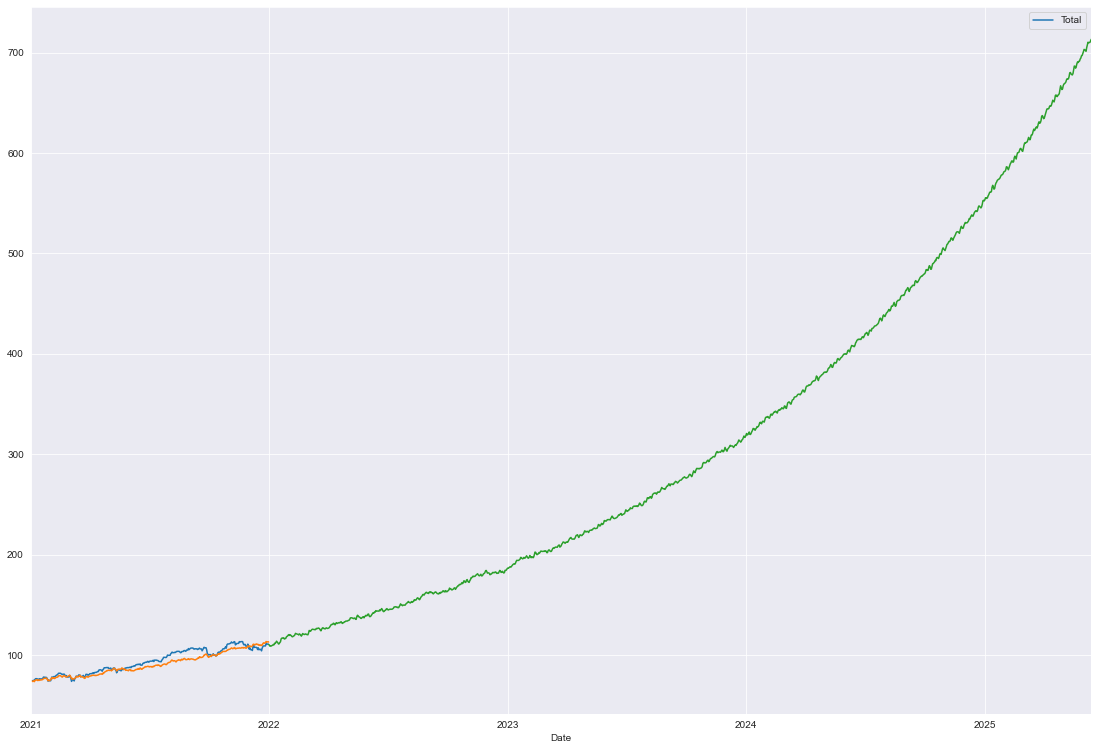

In [38]:
# Set style for seaborn plot
sns.set_style('darkgrid')
# Add automatic datetime converters
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc('figure',figsize=(19, 13))

# Set fig and ax
fig, ax = plt.subplots()

# Figure out optimum lags for this data set
lags = ar_select_order(tot_port_df, maxlag=30)
print("Lags :", lags.ar_lags)

# Create our model using whole data set
model = AutoReg(tot_port_df['Total'], lags.ar_lags)
model_fit = model.fit()

# Define training and testing area
print("Observations :", len(tot_port_df)) # 1095 observations

train_df = tot_port_df.iloc[0:1459] # First 80% 
test_df = tot_port_df.iloc[1459:] # Last 20%

# Define training model for 459 days (Play with Number & Test)
# and White's covariance estimator
train_model = AutoReg(tot_port_df['Total'], 459).fit(cov_type="HC0")

# # Define start and end for prediction 
start = len(train_df)
end = len(train_df) + len(test_df) - 1

prediction = train_model.predict(start=start, end=end, dynamic=True)

# Plot testing data with prediction
ax = test_df.plot(ax=ax) # blue
ax = prediction.plot(ax=ax) # orange

# Predict 60 days into the future
forecast = train_model.predict(start=end, end=end+1260, dynamic=True)
ax = forecast.plot(ax=ax) # Green

## Calculate annualized returns for forecasted

In [39]:
forecast

2021-12-31    110.443787
2022-01-01    109.829715
2022-01-02    108.757242
2022-01-03    108.989230
2022-01-04    108.972514
                 ...    
2025-06-09    709.707145
2025-06-10    709.893880
2025-06-11    710.147009
2025-06-12    711.791841
2025-06-13    713.210933
Freq: D, Length: 1261, dtype: float64

In [40]:
forecast_df = pd.DataFrame(forecast)

In [41]:
forecast_df

,0
2021-12-31,110.443787
2022-01-01,109.829715
2022-01-02,108.757242
2022-01-03,108.989230
2022-01-04,108.972514
...,...
2025-06-09,709.707145
2025-06-10,709.893880
2025-06-11,710.147009
2025-06-12,711.791841


In [42]:
return_series = (1 + forecast_df.pct_change()).cumprod() - 1

In [43]:
return_series

,0
2021-12-31,NaN
2022-01-01,-0.005560
2022-01-02,-0.015271
2022-01-03,-0.013170
2022-01-04,-0.013321
...,...
2025-06-09,5.425958
2025-06-10,5.427649
2025-06-11,5.429941
2025-06-12,5.444834


In [44]:
#calculate annualized return
total_return = return_series.tail(1)

annualized_return = ((1 + total_return)**(1/5))-1

print(annualized_return*100)

                    0
2025-06-13  45.216291
